# MLP for Image Classification

In this Lab practice you will need to use some of the functions generated in the first ungraded practice related to logistic regression but most of the work will be related to programming MLP helper functions and test that the deep model works. Later you will try a variety of meta-parameters to see if you can beat other classmates. The final purpose is understanding the learning process in depth and comparing the image classification performance of a logistic regressor (first practice), and a MLP with different configurations and meta-parameters. 
This notebook has been adapted from a couple of notebooks from Coursera. Don't post the solutions in GitHub because that breaks the Honor Code of that course.

Let's get started!

## 0 - Mounting the personal Google Drive space
This will allow you to have your data in your Google Drive and use it in your temporal Colab space whenever you need it. Change the folder to the place you have your notebook and data. In my case is in *ColabNotebooks/AMLCV*. 

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/ColabNotebooks/AMLCV

Mounted at /content/drive
/content/drive/MyDrive/ColabNotebooks/AMLCV


## 1 - Packages

Let's first import all the packages that you will need during this assignment. 
- [numpy](https://www.numpy.org/) is the fundamental package for scientific computing with Python.
- [matplotlib](http://matplotlib.org) is a library to plot graphs in Python.
- [h5py](http://www.h5py.org) is a common package to interact with a dataset that is stored on an H5 file.
- [cv2](http://opencv.orf) is the OpenCV library that we will use just for simple image operations in the final part of this notebook
- MLP_utils provides some functions that you don't need to program.
- np.random.seed(1) is used to keep all the random function calls consistent. It will help you to verify your code.

In [2]:
import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
import cv2
import sys
sys.path.append('/content/MyDrive/ColabNotebooks/AMLCV')
from MLP_utils import *
from test import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1) # if you change the seed the pre-calculated auto-tests in the "test" python file will not throw valid results for you

## 2 - Dataset

You will use the same "Cat vs non-Cat" dataset as in the ungraded practice. The model you had built had 70% test accuracy on classifying cats vs non-cats images. Hopefully, your new model will perform better!

**Problem Statement**: You are given a dataset ("data.h5") containing:
    - a training set of m_train images labelled as cat (1) or non-cat (0)
    - a test set of m_test images labelled as cat and non-cat
    - each image is of shape (num_px, num_px, 3) where 3 is for the 3 channels (RGB).

Let's get more familiar with the dataset. Load the data by running the cell below.

In [3]:
train_x_orig, train_y, test_x_orig, test_y, classes = load_data()

The following code will show you an image in the dataset. Feel free to change the index and re-run the cell multiple times to see other images. 

y = 0. It's a non-cat picture.


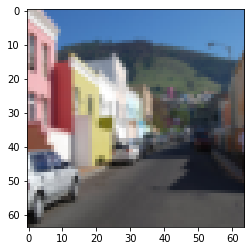

In [4]:
# Example of a picture
index = 1
plt.imshow(train_x_orig[index])
print ("y = " + str(train_y[0,index]) + ". It's a " + classes[train_y[0,index]].decode("utf-8") +  " picture.")

In [5]:
# Explore your dataset 
m_train = train_x_orig.shape[0]
num_px = train_x_orig.shape[1]
m_test = test_x_orig.shape[0]

print ("Number of training examples: " + str(m_train))
print ("Number of testing examples: " + str(m_test))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_x_orig shape: " + str(train_x_orig.shape))
print ("train_y shape: " + str(train_y.shape))
print ("test_x_orig shape: " + str(test_x_orig.shape))
print ("test_y shape: " + str(test_y.shape))

Number of training examples: 209
Number of testing examples: 50
Each image is of size: (64, 64, 3)
train_x_orig shape: (209, 64, 64, 3)
train_y shape: (1, 209)
test_x_orig shape: (50, 64, 64, 3)
test_y shape: (1, 50)


As usual, you reshape and standardize the images before feeding them to the network. The code is given in the cell below.

In [6]:
# Reshape the training and test examples 
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T   # The "-1" makes reshape flatten the remaining dimensions
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

# Standardize data to have feature values between 0 and 1.
train_x = train_x_flatten/255.
test_x = test_x_flatten/255.

print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))


train_x's shape: (12288, 209)
test_x's shape: (12288, 50)


$12,288$ equals $64 \times 64 \times 3$ which is the size of one reshaped image vector.

## 3 - Architecture of your model

Now that you are familiar with the dataset, it is time to build a MLP to tell apart cat images from non-cat images.

You will build An L-layer deep neural network

You will then compare the performance of this model with different values for the meta-parameters. 

Here is a simplified network representation 
**(NOTE: in this notebook the activation variable is 'a' while in the AMLCV lecture is 'v')**:

<img src="https://drive.google.com/uc?id=1JoU2P5dVGu6b660P8AnNZ1a6A4MsteUc" style="width:650px;height:400px;">
<caption><center> <u>Figure 1</u>: L-layer neural network. <br> The model can be summarized as: <b><i>[LINEAR -> RELU] $\times$ (L-1) -> LINEAR -> SIGMOID</b></i></center></caption>

<u>Detailed Architecture of figure 1</u>:
- The input is a (64,64,3) image which is flattened to a vector of size (12288,1).
- The corresponding vector: $[x_0,x_1,...,x_{12287}]^T$ is then multiplied by the weight matrix $W^{[1]}$ and then you add the intercept $b^{[1]}$. The result is called the linear unit.
- Next, you take the relu of the linear unit. This process could be repeated several times for each $(W^{[l]}, b^{[l]})$ depending on the model architecture.
- Finally, you take the sigmoid of the final linear unit. If it is greater than 0.5, you classify it to be a cat.

###  General methodology

Now you will follow a Deep Learning methodology to build the model:
    1. Initialize parameters / Define hyperparameters
    2. Loop for num_iterations:
        a. Forward propagation
        b. Compute cost function
        c. Backward propagation
        d. Update parameters (using parameters, and grads from backprop) 
    4. Use trained parameters to predict labels

Let's now implement this models!

## L-layer neural network

**Question**:  Program  helper functions to build a L-layer neural network with the following structure: *LINEAR -> RELU (L-1) times -> LINEAR -> SIGMOID*. The functions you may need to program and their inputs are:
```python
def initialize_parameters_deep(layer_dims):
    ...
    return parameters 
def linear_activation_forward(A_prev, W, b, activation):
    ...
    return A, cache
def compute_cost(AL, Y):
    ...
    return cost
def linear_activation_backward(dA, cache, activation):
    ...
    return dA_prev, dW, db
def update_parameters(parameters, grads, learning_rate):
    ...
    return parameters
```

The initialization for a deeper L-layer neural network is tricky because there are many  weight matrices and bias vectors. When completing the `initialize_parameters_deep`, you should make sure that your dimensions match between each layer. Recall that $n^{[l]}$ is the number of units in layer $l$. 

**Exercise**: Implement initialization for an L-layer Neural Network. 

**Instructions**:
- The model's structure is *[LINEAR -> RELU] $ \times$ (L-1) -> LINEAR -> SIGMOID*. I.e., it has $L-1$ layers using a ReLU activation function followed by an output layer with a sigmoid activation function.
- Use Kaiming (or He) initialization for the weight matrices as explained in the lecture. 
- Use zeros initialization for the biases. Use `np.zeros(shape)`.
- We will store $n^{[l]}$, the number of units in different layers, in a variable `layer_dims`. For example, the `layer_dims` for a 2-layers MLP with bi-dimensional input, 4 nodes in the hidden layer and binary output could be [2,4,1]. This means `W1`'s shape was (4,2), `b1` was (4,1), `W2` was (1,4) and `b2` was (1,1). Now you will generalize this to $L$ layers! 
- Here is the implementation for $L=1$ (one layer neural network). It should inspire you to implement the general case (L-layer neural network).
```python
    if L == 1:
        parameters["W" + str(L)] = np.random.randn(layer_dims[1], layer_dims[0])*np.sqrt(2/layer_dims[0])
        parameters["b" + str(L)] = np.zeros((layer_dims[1], 1))
```

In [7]:
def initialize_parameters_deep(layer_dims):
    """
    Arguments:
    layer_dims -- python array (list) containing the dimensions of each layer in our network
    
    Returns:
    parameters -- python dictionary containing your parameters "W1", "b1", ..., "WL", "bL":
                    Wl -- weight matrix of shape (layer_dims[l], layer_dims[l-1])
                    bl -- bias vector of shape (layer_dims[l], 1)
    """
    
    np.random.seed(3)
    parameters = {}
    L = len(layer_dims)            # number of layers in the network

    for l in range(1, L):
        ### START CODE HERE ### (≈ 2 lines of code)
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1])*np.sqrt(2/layer_dims[l-1])
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
        ### END CODE HERE ###
        
        assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l-1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))

        
    return parameters

In [8]:
parameters = initialize_parameters_deep([5,4,3])
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

W1 = [[ 1.13122797  0.27607307  0.06103036 -1.17857627 -0.1754357 ]
 [-0.22436928 -0.05233031 -0.39655005 -0.02771304 -0.30181918]
 [-0.83096103  0.55948432  0.55739447  1.08122894  0.03164405]
 [-0.25594047 -0.34491592 -0.97807813  0.62130372 -0.69637631]]
b1 = [[0.]
 [0.]
 [0.]
 [0.]]
W2 = [[-0.83795444 -0.14541644  1.05086558  0.16738368]
 [-0.72392541 -0.50416233  0.44211496 -0.11350009]
 [-0.5436494  -0.16265628  0.52683434  1.39732134]]
b2 = [[0.]
 [0.]
 [0.]]


**Expected output**:
       
<table style="width:80%">
  <tr>
    <td> <b>W1</b> </td>
    <td>[[ 1.13122797  0.27607307  0.06103036 -1.17857627 -0.1754357 ]
 [-0.22436928 -0.05233031 -0.39655005 -0.02771304 -0.30181918]
 [-0.83096103  0.55948432  0.55739447  1.08122894  0.03164405]
 [-0.25594047 -0.34491592 -0.97807813  0.62130372 -0.69637631]]</td> 
  </tr>
  
  <tr>
    <td><b>b1</b> </td>
    <td>[[ 0.]
 [ 0.]
 [ 0.]
 [ 0.]]</td> 
  </tr>
  
  <tr>
    <td><b>W2</b> </td>
    <td>[[-0.83795444 -0.14541644  1.05086558  0.16738368]
 [-0.72392541 -0.50416233  0.44211496 -0.11350009]
 [-0.5436494  -0.16265628  0.52683434  1.39732134]]</td> 
  </tr>
  
  <tr>
    <td><b>b2</b> </td>
    <td>[[ 0.]
 [ 0.]
 [ 0.]]</td> 
  </tr>
  
</table>

## 4 - Forward propagation module

### 4.1 - Linear Forward 
Now that you have initialized your parameters, you will do the forward propagation module. You will start by implementing some basic functions that you will use later when implementing the model. You will complete three functions in this order:

- LINEAR
- LINEAR -> ACTIVATION where ACTIVATION will be either ReLU or Sigmoid. 
- [LINEAR -> RELU] $\times$ (L-1) -> LINEAR -> SIGMOID (whole model)

The linear forward module (vectorized over all the examples) computes the following equations:

$$Z^{[l]} = W^{[l]}A^{[l-1]} +b^{[l]}\tag{4}$$

where $A^{[0]} = X$. 

**Exercise**: Build the linear part of forward propagation.

**Reminder**:
The mathematical representation of this unit is $Z^{[l]} = W^{[l]}A^{[l-1]} +b^{[l]}$. You may also find `np.dot()` useful. If your dimensions don't match, printing `W.shape` may help.

In [9]:
def linear_forward(A, W, b):
    """
    Implement the linear part of a layer's forward propagation.

    Arguments:
    A -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)

    Returns:
    Z -- the input of the activation function, also called pre-activation parameter 
    cache -- a python tuple containing "A", "W" and "b" ; stored for computing the backward pass efficiently
    """
    
    ### START CODE HERE ### (≈ 1 line of code)
    Z = np.dot(W, A) + b
    ### END CODE HERE ###
    
    assert(Z.shape == (W.shape[0], A.shape[1]))
    cache = (A, W, b)
    
    return Z, cache

In [10]:
A, W, b = linear_forward_test_case() # short pre-computed numerical example to test your function

Z, linear_cache = linear_forward(A, W, b)
print("Z = " + str(Z))

Z = [[ 3.26295337 -1.23429987]]


**Expected output**:

<table style="width:35%">
  
  <tr>
    <td> <b>Z</b> </td>
    <td> [[ 3.26295337 -1.23429987]] </td> 
  </tr>
  
</table>

### 4.2 - Linear-Activation Forward

In this notebook, you will use two activation functions:

- **Sigmoid**: $\sigma(Z) = \sigma(W A + b) = \frac{1}{ 1 + e^{-(W A + b)}}$. We have provided you with the `sigmoid` function in the file *MLP_utils.py*. This function returns **two** items: the activation value "`a`" and a "`cache`" that contains "`Z`" (it's what we will feed in to the corresponding backward function). To use it you could just call: 
``` python
A, activation_cache = sigmoid(Z)
```

- **ReLU**: The mathematical formula for ReLu is $A = RELU(Z) = max(0, Z)$. We have provided you with the `relu` function in the file *MLP_utils.py*. This function returns **two** items: the activation value "`A`" and a "`cache`" that contains "`Z`" (it's what we will feed in to the corresponding backward function). To use it you could just call:
``` python
A, activation_cache = relu(Z)
```

For more convenience, you are going to group two functions (Linear and Activation) into one function (LINEAR->ACTIVATION). Hence, you will implement a function that does the LINEAR forward step followed by an ACTIVATION forward step.

**Exercise**: Implement the forward propagation of the *LINEAR->ACTIVATION* layer. Mathematical relation is: $A^{[l]} = g(Z^{[l]}) = g(W^{[l]}A^{[l-1]} +b^{[l]})$ where the activation "g" can be sigmoid() or relu(). Use linear_forward() and the correct activation function.

In [11]:
def linear_activation_forward(A_prev, W, b, activation):
    """
    Implement the forward propagation for the LINEAR->ACTIVATION layer

    Arguments:
    A_prev -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"

    Returns:
    A -- the output of the activation function, also called the post-activation value 
    cache -- a python tuple containing "linear_cache" and "activation_cache";
             stored for computing the backward pass efficiently
    """
    
    if activation == "sigmoid":
        # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".
        ### START CODE HERE ### (≈ 2 lines of code)
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)
        ### END CODE HERE ###
    
    elif activation == "relu":
        # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".
        ### START CODE HERE ### (≈ 2 lines of code)
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)
        ### END CODE HERE ###
    
    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    cache = (linear_cache, activation_cache)

    return A, cache

In [12]:
A_prev, W, b = linear_activation_forward_test_case()

A, linear_activation_cache = linear_activation_forward(A_prev, W, b, activation = "sigmoid")
print("With sigmoid: A = " + str(A))

A, linear_activation_cache = linear_activation_forward(A_prev, W, b, activation = "relu")
print("With ReLU: A = " + str(A))

With sigmoid: A = [[0.96890023 0.11013289]]
With ReLU: A = [[3.43896131 0.        ]]


**Expected output**:
       
<table style="width:35%">
  <tr>
    <td> <b>With sigmoid: A </b> </td>
    <td > [[ 0.96890023  0.11013289]]</td> 
  </tr>
  <tr>
    <td> <b>With ReLU: A </b> </td>
    <td > [[ 3.43896131  0.        ]]</td> 
  </tr>
</table>

### d) L-Layer Model 

For even more convenience when implementing the $L$-layer Neural Net, you will need a function that replicates the previous one (`linear_activation_forward` with RELU) $L-1$ times, then follows that with one `linear_activation_forward` with SIGMOID.

**Exercise**: Implement the forward propagation of the above model.

**Instruction**: In the code below, the variable `AL` will denote $A^{[L]} = \sigma(Z^{[L]}) = \sigma(W^{[L]} A^{[L-1]} + b^{[L]})$. (This is sometimes also called `Yhat`, i.e., this is $\hat{Y}$.) 

**Tips**:
- Use the functions you had previously written 
- Use a for loop to replicate [LINEAR->RELU] (L-1) times
- Don't forget to keep track of the caches in the "caches" list. To add a new value `c` to a `list`, you can use `list.append(c)`.

In [13]:
def L_model_forward(X, parameters):
    """
    Implement forward propagation for the [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID computation
    
    Arguments:
    X -- data, numpy array of shape (input size, number of examples)
    parameters -- output of initialize_parameters_deep()
    
    Returns:
    AL -- last post-activation value
    caches -- list of caches containing:
                every cache of linear_activation_forward() (there are L-1 of them, indexed from 0 to L-1)
    """

    caches = []
    A = X
    L = len(parameters) // 2                  # number of layers in the neural network
    
    # Implement [LINEAR -> RELU]*(L-1). Add "cache" to the "caches" list.
    for l in range(1, L):
        A_prev = A 
        ### START CODE HERE ### (≈ 2 lines of code)
        A, cache = linear_activation_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], 'relu')
        caches.append(cache)
        ### END CODE HERE ###
    
    # Implement LINEAR -> SIGMOID. Add "cache" to the "caches" list.
    ### START CODE HERE ### (≈ 2 lines of code)
    AL, cache = linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], 'sigmoid')
    caches.append(cache)
    ### END CODE HERE ###
    
    assert(AL.shape == (1,X.shape[1]))
            
    return AL, caches

In [14]:
X, parameters = L_model_forward_test_case_2hidden()
AL, caches = L_model_forward(X, parameters)
print("AL = " + str(AL))
print("Length of caches list = " + str(len(caches)))

AL = [[0.03921668 0.70498921 0.19734387 0.04728177]]
Length of caches list = 3


<table style="width:50%">
  <tr>
    <td> <b>AL</b> </td>
    <td > [[ 0.03921668  0.70498921  0.19734387  0.04728177]]</td> 
  </tr>
  <tr>
    <td> <b>Length of caches list </b> </td>
    <td > 3 </td> 
  </tr>
</table>

Great! Now you have a full forward propagation that takes the input X and 

1.   Elemento de lista

1.   Elemento de lista
2.   Elemento de lista


2.   Elemento de lista

outputs a row vector $A^{[L]}$ (or $\hat{Y}$) containing your predictions. It also records all intermediate values in "caches". Using $A^{[L]}$, you can compute the cost of your predictions.

## 5 - Cost function

Now you will implement forward and backward propagation. You need to compute the cost, because you want to check if your model is actually learning.

**Exercise**: Compute the cross-entropy cost $J$, using the following formula: $$-\frac{1}{m} \sum\limits_{i = 1}^{m} (y^{(i)}\log\left(a^{[L] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[L](i)}\right)) \tag{7}$$

In [15]:
def compute_cost(AL, Y):
    """
    Implement the cost function defined by equation (7).

    Arguments:
    AL -- probability vector corresponding to your label predictions, shape (1, number of examples)
    Y -- true "label" vector (for example: containing 0 if non-cat, 1 if cat), shape (1, number of examples)

    Returns:
    cost -- cross-entropy cost
    """
    
    m = Y.shape[1]

    # Compute loss from aL and y.
    ### START CODE HERE ### (≈ 1 lines of code)
    cost = -np.mean(Y * np.log(AL) + (1 - Y) * np.log(1 - AL))
    ### END CODE HERE ###
    
    cost = np.squeeze(cost)      # To make sure your cost's shape is what we expect (e.g. this turns [[17]] into 17).
    assert(cost.shape == ())
    
    return cost

In [16]:
Y, AL = compute_cost_test_case()

print("cost = " + str(compute_cost(AL, Y)))

cost = 0.2797765635793423


**Expected Output**:

<table style="width:50%">
    <tr>
        <td><b>cost</b> </td>
        <td> 0.2797765635793422</td> 
    </tr>
</table>

## 6 - Backward propagation module

Just like with forward propagation, you will implement helper functions for backpropagation. Remember that back propagation is used to calculate the gradient of the loss function with respect to the parameters. 

In order to calculate the gradient $dW^{[1]} = \frac{\partial L}{\partial W^{[1]}}$, you use the  chain rule and you do $dW^{[1]} = dz^{[1]} \times \frac{\partial z^{[1]} }{\partial W^{[1]}}$. During the backpropagation, at each step you multiply your current gradient by the gradient corresponding to the specific layer to get the gradient you wanted.

Equivalently, in order to calculate the gradient $db^{[1]} = \frac{\partial L}{\partial b^{[1]}}$, you use the  chain rule and you do $db^{[1]} = dz^{[1]} \times \frac{\partial z^{[1]} }{\partial b^{[1]}}$.

This is why we talk about **backpropagation**.
!-->

Now, similar to forward propagation, you are going to build the backward propagation in three steps:
- LINEAR backward
- LINEAR -> ACTIVATION backward where ACTIVATION computes the derivative of either the ReLU or sigmoid activation
- [LINEAR -> RELU] $\times$ (L-1) -> LINEAR -> SIGMOID backward (whole model)

### 6.1 - Linear backward

For layer $l$, the linear part is: $Z^{[l]} = W^{[l]} A^{[l-1]} + b^{[l]}$ (followed by an activation).

Suppose you have already calculated the derivative $dZ^{[l]} = \frac{\partial \mathcal{L} }{\partial Z^{[l]}}$. You want to get $(dW^{[l]}, db^{[l]}, dA^{[l-1]})$.


The three outputs $(dW^{[l]}, db^{[l]}, dA^{[l-1]})$ are computed using the input $dZ^{[l]}$.Here are the formulas you need:
$$ dW^{[l]} = \frac{\partial \mathcal{J} }{\partial W^{[l]}} = \frac{1}{m} dZ^{[l]} A^{[l-1] T} \tag{8}$$
$$ db^{[l]} = \frac{\partial \mathcal{J} }{\partial b^{[l]}} = \frac{1}{m} \sum_{i = 1}^{m} dZ^{[l](i)}\tag{9}$$
$$ dA^{[l-1]} = \frac{\partial \mathcal{L} }{\partial A^{[l-1]}} = W^{[l] T} dZ^{[l]} \tag{10}$$


**Exercise**: Use the 3 formulas above to implement linear_backward().

In [17]:
def linear_backward(dZ, cache):
    """
    Implement the linear portion of backward propagation for a single layer (layer l)

    Arguments:
    dZ -- Gradient of the cost with respect to the linear output (of current layer l)
    cache -- tuple of values (A_prev, W, b) coming from the forward propagation in the current layer

    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    A_prev, W, b = cache
    m = A_prev.shape[1]

    ### START CODE HERE ### (≈ 3 lines of code)
    dW = (1/m) * np.dot(dZ, A_prev.T)
    db = ((1/m) * np.sum(dZ, axis=1)).reshape((-1,1))
    dA_prev = np.dot(W.T, dZ)
    ### END CODE HERE ###
    
    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)
    
    return dA_prev, dW, db

In [18]:
# Set up some test inputs
dZ, linear_cache = linear_backward_test_case()

dA_prev, dW, db = linear_backward(dZ, linear_cache)
print ("dA_prev = "+ str(dA_prev))
print ("dW = " + str(dW))
print ("db = " + str(db))

dA_prev = [[-1.15171336  0.06718465 -0.3204696   2.09812712]
 [ 0.60345879 -3.72508701  5.81700741 -3.84326836]
 [-0.4319552  -1.30987417  1.72354705  0.05070578]
 [-0.38981415  0.60811244 -1.25938424  1.47191593]
 [-2.52214926  2.67882552 -0.67947465  1.48119548]]
dW = [[ 0.07313866 -0.0976715  -0.87585828  0.73763362  0.00785716]
 [ 0.85508818  0.37530413 -0.59912655  0.71278189 -0.58931808]
 [ 0.97913304 -0.24376494 -0.08839671  0.55151192 -0.10290907]]
db = [[-0.14713786]
 [-0.11313155]
 [-0.13209101]]


**Expected Output:**
    
```
dA_prev = 
 [[-1.15171336  0.06718465 -0.3204696   2.09812712]
 [ 0.60345879 -3.72508701  5.81700741 -3.84326836]
 [-0.4319552  -1.30987417  1.72354705  0.05070578]
 [-0.38981415  0.60811244 -1.25938424  1.47191593]
 [-2.52214926  2.67882552 -0.67947465  1.48119548]]
dW = 
 [[ 0.07313866 -0.0976715  -0.87585828  0.73763362  0.00785716]
 [ 0.85508818  0.37530413 -0.59912655  0.71278189 -0.58931808]
 [ 0.97913304 -0.24376494 -0.08839671  0.55151192 -0.10290907]]
db = 
 [[-0.14713786]
 [-0.11313155]
 [-0.13209101]]
```

### 6.2 - Linear-Activation backward

Next, you will create a function that merges the two helper functions: 

**`linear_backward`** and the backward step for the activation **`linear_activation_backward`**. 

To help you implement `linear_activation_backward`, we provided two backward functions  in the *MLP_utils.py* file:
- **`sigmoid_backward`**: Implements the backward propagation for SIGMOID unit. You can call it as follows:

```python
dZ = sigmoid_backward(dA, activation_cache)
```

- **`relu_backward`**: Implements the backward propagation for RELU unit. You can call it as follows:

```python
dZ = relu_backward(dA, activation_cache)
```

If $g(.)$ is the activation function, 
`sigmoid_backward` and `relu_backward` compute $$dZ^{[l]} = dA^{[l]} * g'(Z^{[l]}) \tag{11}$$.  

**Exercise**: Implement the backpropagation for the *LINEAR->ACTIVATION* layer.

In [19]:
def linear_activation_backward(dA, cache, activation):
    """
    Implement the backward propagation for the LINEAR->ACTIVATION layer.
    
    Arguments:
    dA -- post-activation gradient for current layer l 
    cache -- tuple of values (linear_cache, activation_cache) we store for computing backward propagation efficiently
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"
    
    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    linear_cache, activation_cache = cache
    
    if activation == "relu":
        ### START CODE HERE ### (≈ 2 lines of code)
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
        ### END CODE HERE ###
        
    elif activation == "sigmoid":
        ### START CODE HERE ### (≈ 2 lines of code)
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
        ### END CODE HERE ###
    
    return dA_prev, dW, db

In [20]:
dAL, linear_activation_cache = linear_activation_backward_test_case()

dA_prev, dW, db = linear_activation_backward(dAL, linear_activation_cache, activation = "sigmoid")
print ("sigmoid:")
print ("dA_prev = "+ str(dA_prev))
print ("dW = " + str(dW))
print ("db = " + str(db) + "\n")

dA_prev, dW, db = linear_activation_backward(dAL, linear_activation_cache, activation = "relu")
print ("relu:")
print ("dA_prev = "+ str(dA_prev))
print ("dW = " + str(dW))
print ("db = " + str(db))

sigmoid:
dA_prev = [[ 0.11017994  0.01105339]
 [ 0.09466817  0.00949723]
 [-0.05743092 -0.00576154]]
dW = [[ 0.10266786  0.09778551 -0.01968084]]
db = [[-0.05729622]]

relu:
dA_prev = [[ 0.44090989  0.        ]
 [ 0.37883606  0.        ]
 [-0.2298228   0.        ]]
dW = [[ 0.44513824  0.37371418 -0.10478989]]
db = [[-0.20837892]]


**Expected output with sigmoid:**

<table style="width:100%">
  <tr>
    <td > dA_prev </td> 
           <td >[[ 0.11017994  0.01105339]
 [ 0.09466817  0.00949723]
 [-0.05743092 -0.00576154]] </td> 
  </tr> 
    <tr>
    <td > dW </td> 
           <td > [[ 0.10266786  0.09778551 -0.01968084]] </td> 
  </tr>   
    <tr>
    <td > db </td> 
           <td > [[-0.05729622]] </td> 
  </tr> 
</table>


**Expected output with relu:**

<table style="width:100%">
  <tr>
    <td > dA_prev </td> 
           <td > [[ 0.44090989  0.        ]
 [ 0.37883606  0.        ]
 [-0.2298228   0.        ]] </td> 
  </tr> 
    <tr>
    <td > dW </td> 
           <td > [[ 0.44513824  0.37371418 -0.10478989]] </td> 
  </tr> 
    <tr>
    <td > db </td> 
           <td > [[-0.20837892]] </td> 
  </tr> 
</table>


### 6.3 - L-Model Backward 

Now you will implement the backward function for the whole network. Recall that when you implemented the `L_model_forward` function, at each iteration, you stored a cache which contains (X,W,b, and z). In the back propagation module, you will use those variables to compute the gradients. Therefore, in the `L_model_backward` function, you will iterate through all the hidden layers backward, starting from layer $L$. On each step, you will use the cached values for layer $l$ to backpropagate through layer $l$. 

**Initializing backpropagation:**
To backpropagate through this network, we know that the output is, 
$A^{[L]} = \sigma(Z^{[L]})$. Your code thus needs to compute `dAL` $= \frac{\partial \mathcal{L}}{\partial A^{[L]}}$.
To do so, use the derivative shown in the AMLCV lecture (there using $\hat{Y}$):
```python
dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL)) # derivative of cost with respect to AL
```

You can then use this post-activation gradient `dAL` to keep going backward. As seen in Figure 5, you can now feed in `dAL` into the LINEAR->SIGMOID backward function you implemented (which will use the cached values stored by the L_model_forward function). After that, you will have to use a `for` loop to iterate through all the other layers using the LINEAR->RELU backward function. You should store each dA, dW, and db in the grads dictionary. To do so, use this formula : 

$$grads[''dW'' + str(l)] = dW^{[l]}\tag{15} $$

For example, for $l=3$ this would store $dW^{[l]}$ in `grads["dW3"]`.

**Exercise**: Implement backpropagation for the *[LINEAR->RELU] $\times$ (L-1) -> LINEAR -> SIGMOID* model.

In [21]:
def L_model_backward(AL, Y, caches):
    """
    Implement the backward propagation for the [LINEAR->RELU] * (L-1) -> LINEAR -> SIGMOID group
    
    Arguments:
    AL -- probability vector, output of the forward propagation (L_model_forward())
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat)
    caches -- list of caches containing:
                every cache of linear_activation_forward() with "relu" (it's caches[l], for l in range(L-1) i.e l = 0...L-2)
                the cache of linear_activation_forward() with "sigmoid" (it's caches[L-1])
    
    Returns:
    grads -- A dictionary with the gradients
             grads["dA" + str(l)] = ... 
             grads["dW" + str(l)] = ...
             grads["db" + str(l)] = ... 
    """
    grads = {}
    L = len(caches) # the number of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL
    
    # Initializing the backpropagation
    ### START CODE HERE ### (1 line of code)
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    ### END CODE HERE ###
    
    # Lth layer (SIGMOID -> LINEAR) gradients. Inputs: "dAL, current_cache". Outputs: "grads["dAL-1"], grads["dWL"], grads["dbL"]
    ### START CODE HERE ### (approx. 2 lines)
    current_cache = caches[-1]
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, 'sigmoid')
    ### END CODE HERE ###
    
    # Loop from l=L-2 to l=0
    for l in reversed(range(L-1)):
        # lth layer: (RELU -> LINEAR) gradients.
        # Inputs: "grads["dA" + str(l + 1)], current_cache". Outputs: "grads["dA" + str(l)] , grads["dW" + str(l + 1)] , grads["db" + str(l + 1)] 
        ### START CODE HERE ### (approx. 5 lines)
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 1)], current_cache, 'relu')
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp
        ### END CODE HERE ###

    return grads

In [22]:
AL, Y_assess, caches = L_model_backward_test_case()
grads = L_model_backward(AL, Y_assess, caches)
print_grads(grads)

dW1 = [[0.41010002 0.07807203 0.13798444 0.10502167]
 [0.         0.         0.         0.        ]
 [0.05283652 0.01005865 0.01777766 0.0135308 ]]
db1 = [[-0.22007063]
 [ 0.        ]
 [-0.02835349]]
dA1 = [[ 0.12913162 -0.44014127]
 [-0.14175655  0.48317296]
 [ 0.01663708 -0.05670698]]


**Expected Output**

<table style="width:60%"> 
  <tr>
    <td > dW1 </td> 
           <td > [[ 0.41010002  0.07807203  0.13798444  0.10502167]
 [ 0.          0.          0.          0.        ]
 [ 0.05283652  0.01005865  0.01777766  0.0135308 ]] </td> 
  </tr>  
    <tr>
    <td > db1 </td> 
           <td > [[-0.22007063]
 [ 0.        ]
 [-0.02835349]] </td> 
  </tr>   
  <tr>
  <td > dA1 </td> 
           <td > [[ 0.12913162 -0.44014127]
 [-0.14175655  0.48317296]
 [ 0.01663708 -0.05670698]] </td> 

  </tr> 
</table>

### 6.4 - Update Parameters

In this section you will update the parameters of the model, using gradient descent: 

$$ W^{[l]} = W^{[l]} - \alpha \text{ } dW^{[l]} \tag{16}$$
$$ b^{[l]} = b^{[l]} - \alpha \text{ } db^{[l]} \tag{17}$$

where $\alpha$ is the learning rate. After computing the updated parameters, store them in the parameters dictionary. 

**Exercise**: Implement `update_parameters()` to update your parameters using gradient descent.

**Instructions**:
Update parameters using gradient descent on every $W^{[l]}$ and $b^{[l]}$ for $l = 1, 2, ..., L$. 


In [23]:
def update_parameters(parameters, grads, learning_rate):
    """
    Update parameters using gradient descent
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    grads -- python dictionary containing your gradients, output of L_model_backward
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
                  parameters["W" + str(l)] = ... 
                  parameters["b" + str(l)] = ...
    """
    
    L = len(parameters) // 2 # number of layers in the neural network

    # Update rule for each parameter. Use a for loop.
    ### START CODE HERE ### (≈ 2 lines of code)
    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l + 1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l + 1)]
    ### END CODE HERE ###
    return parameters

In [24]:
parameters, grads = update_parameters_test_case()
parameters = update_parameters(parameters, grads, 0.1)

print ("W1 = "+ str(parameters["W1"]))
print ("b1 = "+ str(parameters["b1"]))
print ("W2 = "+ str(parameters["W2"]))
print ("b2 = "+ str(parameters["b2"]))

W1 = [[-0.59562069 -0.09991781 -2.14584584  1.82662008]
 [-1.76569676 -0.80627147  0.51115557 -1.18258802]
 [-1.0535704  -0.86128581  0.68284052  2.20374577]]
b1 = [[-0.04659241]
 [-1.28888275]
 [ 0.53405496]]
W2 = [[-0.55569196  0.0354055   1.32964895]]
b2 = [[-0.84610769]]


**Expected Output**:

<table style="width:100%"> 
    <tr>
    <td > W1 </td> 
           <td > [[-0.59562069 -0.09991781 -2.14584584  1.82662008]
 [-1.76569676 -0.80627147  0.51115557 -1.18258802]
 [-1.0535704  -0.86128581  0.68284052  2.20374577]] </td> 
  </tr> 
    <tr>
    <td > b1 </td> 
           <td > [[-0.04659241]
 [-1.28888275]
 [ 0.53405496]] </td> 
  </tr> 
  <tr>
    <td > W2 </td> 
           <td > [[-0.55569196  0.0354055   1.32964895]]</td> 
  </tr>   
    <tr>
    <td > b2 </td> 
           <td > [[-0.84610769]] </td> 
  </tr> 
</table>

## Building a model

Congrats on implementing all the functions required for building a deep neural network! 

The next part of the assignment is easier. 

In the next part you will put all these together to build a L-layer neural network

You will use these model to classify cat vs non-cat images

In [25]:
### CONSTANTS ###
layers_dims = [12288, 20, 7, 5, 1]#  4-layer model

In [26]:
def L_layer_model(X, Y, layers_dims, learning_rate = 0.009, num_iterations = 2000, print_cost=False):
    """
    Implements a L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.
    
    Arguments:
    X -- data, numpy array of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    layers_dims -- list containing the input size and each layer size, of length (number of layers + 1).
    learning_rate -- learning rate of the gradient descent update rule
    num_iterations -- number of iterations of the optimization loop
    print_cost -- if True, it prints the cost every 100 steps
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """

    np.random.seed(1)
    costs = []                         # keep track of cost
    
    # Parameters initialization. (≈ 1 line of code)
    ### START CODE HERE ###
    parameters = initialize_parameters_deep(layers_dims)
    ### END CODE HERE ###
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        ### START CODE HERE ### (≈ 1 line of code)
        AL, caches = L_model_forward(X, parameters)
        ### END CODE HERE ###
        
        # Compute cost.
        ### START CODE HERE ### (≈ 1 line of code)
        cost = compute_cost(AL, Y)
        ### END CODE HERE ###
    
        # Backward propagation.
        ### START CODE HERE ### (≈ 1 line of code)
        grads = L_model_backward(AL, Y, caches)
        ### END CODE HERE ###
 
        # Update parameters.
        ### START CODE HERE ### (≈ 1 line of code)
        parameters = update_parameters(parameters, grads, learning_rate)
        ### END CODE HERE ###
                
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
            
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

You will now train the model as a 4-layer neural network. 

Run the cell below to train your model. The cost should decrease on every iteration. It may take up to 3 minutes to run 1500 iterations. Check if the "Cost after iteration 0" matches the expected output below, if not click on the square (⬛) on the upper bar of the notebook to stop the cell and try to find your error.

Cost after iteration 0: 0.811602
Cost after iteration 100: 0.665533
Cost after iteration 200: 0.627203
Cost after iteration 300: 0.571514
Cost after iteration 400: 0.499363
Cost after iteration 500: 0.387675
Cost after iteration 600: 0.272254
Cost after iteration 700: 0.180160
Cost after iteration 800: 0.115223
Cost after iteration 900: 0.078079
Cost after iteration 1000: 0.046890
Cost after iteration 1100: 0.032229
Cost after iteration 1200: 0.023901
Cost after iteration 1300: 0.018561
Cost after iteration 1400: 0.014870


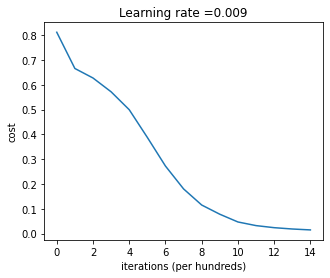

In [27]:
parameters = L_layer_model(train_x, train_y, layers_dims, num_iterations = 1500, print_cost = True)

**Expected Output**:
<table> 
    <tr>
        <td> <b>Cost after iteration 0</b></td>
        <td> 0.811602 </td>
    </tr>
    <tr>
        <td> <b>Cost after iteration 100</b></td>
        <td> 0.665533 </td>
    </tr>
    <tr>
        <td> <b>...</b></td>
        <td> ... </td>
    </tr>
    <tr>
        <td> <b>Cost after iteration 1400</b></td>
        <td> 0.014870 </td>
    </tr>
</table>

In [28]:
def predict(X, y, parameters):
    """
    This function is used to predict the results of a  L-layer neural network.
    
    Arguments:
    X -- data set of examples you would like to label
    parameters -- parameters of the trained model
    
    Returns:
    p -- predictions for the given dataset X
    """
    
    m = X.shape[1]
    n = len(parameters) // 2 # number of layers in the neural network
    p = np.zeros((1,m))
    
    # Forward propagation
    probas, caches = L_model_forward(X, parameters)

    
    # convert probas to 0/1 predictions
    for i in range(0, probas.shape[1]):
        if probas[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0
    
    # print results
    # print ("predictions: " + str(p))
    # print ("true labels: " + str(y))
    print("Accuracy: "  + str(np.sum((p == y)/m)))
        
    return p

In [29]:
pred_train = predict(train_x, train_y, parameters)

Accuracy: 0.9999999999999998


<table>
    <tr>
    <td>
    <b>Train Accuracy</b>
    </td>
    <td>
    0.99
    </td>
    </tr>
</table>

In [30]:
pred_test = predict(test_x, test_y, parameters)

Accuracy: 0.76


**Expected Output**:

<table> 
    <tr>
        <td> <b>Test Accuracy</b></td>
        <td> 0.76 </td>
    </tr>
</table>

Congrats! It seems that your 4-layer neural network has better performance (76%) than your logistic regressor (70%) on the same test set. 

This is good performance for this task. Nice job! 

Though in the next practice you will learn how to obtain even higher accuracy by systematically searching for better hyperparameters.

##  7 - Results Analysis

First, let's take a look at some images the L-layer model labeled incorrectly. This will show a few mislabeled images. 

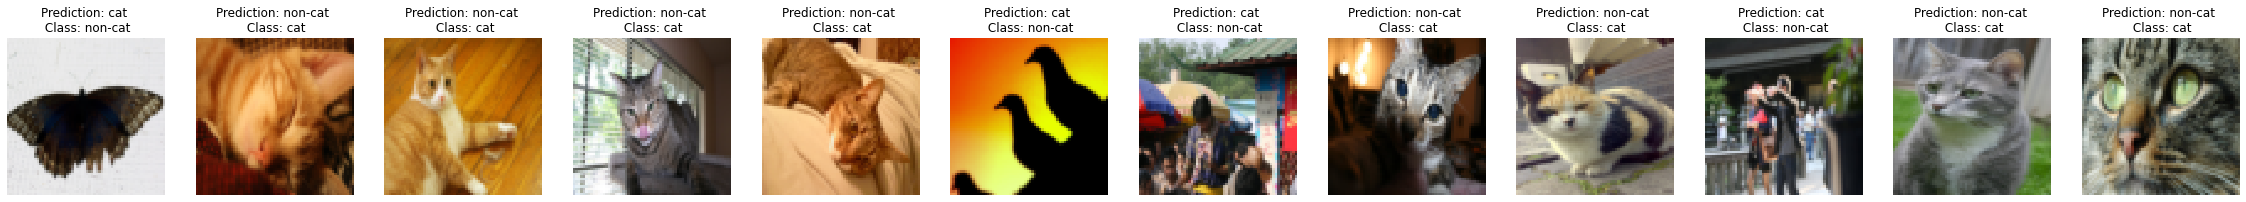

In [31]:
print_mislabeled_images(classes, test_x, test_y, pred_test)

**A few types of images the model tends to do poorly on include:** 
- Cat body in an unusual position
- Cat appears against a background of a similar color
- Unusual cat color and species
- Camera Angle
- Brightness of the picture
- Scale variation (cat is very large or small in image) 

## 8 - Test with your own image ##

Congratulations on finishing this practice. You can use your own image and see the output of your model. 

Accuracy: 1.0
y = 1.0, your algorithm predicts a "cat" picture.


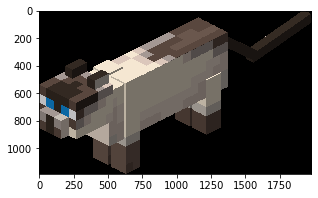

In [32]:
## START CODE HERE ##
my_image = "cat.png" # change this to the name of your image file 
my_label_y = [1] # the true class of your image (1 -> cat, 0 -> non-cat)
## END CODE HERE ##

# We preprocess the image to fit your algorithm.
fname = "images/" + my_image
image = cv2.imread(fname)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.rcParams["figure.figsize"] = (10,3)
plt.imshow(image)
image = image/255.
dim = (num_px, num_px)
my_image = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
my_image_flatten = my_image.reshape((num_px*num_px*3,1))
my_predicted_image = predict(my_image_flatten, my_label_y, parameters)
print("y = " + str(np.squeeze(my_predicted_image)) + ", your algorithm predicts a \"" + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  "\" picture.")
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots


## 9 - Play with: weight initialization, learning rate, number of epochs and complexity ##

### 9.1 Learning rate

Keeping the number of iterations fixed (1500), and for an architecture [20,7,5,1] (4-layer model), we observe how the results vary when the learning rate is modified. 

The following portion of code shows how using a too low learning rate causes the process to stall. During training, the network does not correctly fit the training set, so the cost remains high (underfitting). This is because the parameter updates are very small. As a consequence, the performance of the model on the test set is poor (0.6 accuracy).

Cost after iteration 0: 0.811602
Cost after iteration 100: 0.781361
Cost after iteration 200: 0.757667
Cost after iteration 300: 0.740525
Cost after iteration 400: 0.730065
Cost after iteration 500: 0.723254
Cost after iteration 600: 0.718423
Cost after iteration 700: 0.715359
Cost after iteration 800: 0.712755
Cost after iteration 900: 0.710762
Cost after iteration 1000: 0.709119
Cost after iteration 1100: 0.707811
Cost after iteration 1200: 0.706688
Cost after iteration 1300: 0.705716
Cost after iteration 1400: 0.704839


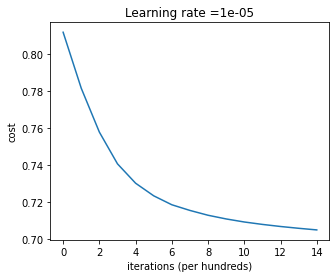

Accuracy: 0.6000000000000001


In [33]:
layers_dims = [12288, 20, 7, 5, 1] #  4-layer model
parameters = L_layer_model(train_x, train_y, layers_dims, learning_rate = 0.00001, num_iterations = 1500, print_cost = True)
pred_test = predict(test_x, test_y, parameters)


Conversely, a too large learning rate causes divergent behavior in the loss function. The updates are larger (so that the minimum is reached earlier), but may be too large and cause oscillating behavior above the minimum. This also leads to a bad test performing (0.7).

Cost after iteration 0: 0.811602
Cost after iteration 100: 0.535587
Cost after iteration 200: 0.650927
Cost after iteration 300: 0.615353
Cost after iteration 400: 0.519248
Cost after iteration 500: 0.581669
Cost after iteration 600: 0.675978
Cost after iteration 700: 0.317049
Cost after iteration 800: 0.560693
Cost after iteration 900: 0.287204
Cost after iteration 1000: 0.309950
Cost after iteration 1100: 0.621186
Cost after iteration 1200: 0.100376
Cost after iteration 1300: 0.630799
Cost after iteration 1400: 0.199727


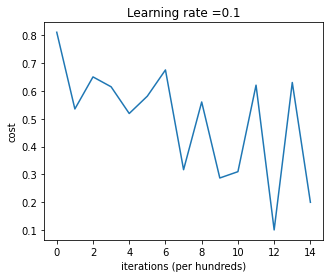

Accuracy: 0.7


In [34]:
parameters = L_layer_model(train_x, train_y, layers_dims, learning_rate = 0.1, num_iterations = 1500, print_cost = True)
pred_test = predict(test_x, test_y, parameters)

After testing a couple of values, we found that a learning rate of 0.8 generates good results (0.78 test accuracy) for this 4-layer architecture. 

Cost after iteration 0: 0.811602
Cost after iteration 100: 0.664462
Cost after iteration 200: 0.632351
Cost after iteration 300: 0.580613
Cost after iteration 400: 0.517793
Cost after iteration 500: 0.438463
Cost after iteration 600: 0.324335
Cost after iteration 700: 0.249344
Cost after iteration 800: 0.160387
Cost after iteration 900: 0.098820
Cost after iteration 1000: 0.077695
Cost after iteration 1100: 0.040390
Cost after iteration 1200: 0.030328
Cost after iteration 1300: 0.023857
Cost after iteration 1400: 0.019687


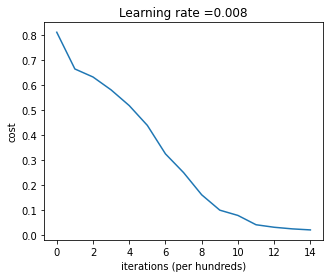

Accuracy: 0.78


In [35]:
parameters = L_layer_model(train_x, train_y, layers_dims, learning_rate = 0.008, num_iterations = 1500, print_cost = True)
pred_test = predict(test_x, test_y, parameters)

### 9.2 - Number of epochs

Keeping the learning rate fixed (0.008), and for an architecture [20,7,5,1] (4-layer model), we observe how the results vary when the number of epochs is modified 

With few iterations (200) the training completes quickly, but the model tends to underfit because not enough updates of the weights have been made to reach the minimum (0.66 train error). This results in poor test performance (0.46).

Cost after iteration 0: 0.811602
Cost after iteration 100: 0.664462


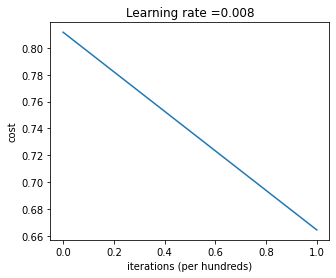

Accuracy: 0.46


In [36]:
parameters = L_layer_model(train_x, train_y, layers_dims, learning_rate = 0.008, num_iterations = 200, print_cost = True)
pred_test = predict(test_x, test_y, parameters)

In this case, the appropriate value (i.e., the one that allows us to reach a good solution in the shortest possible time) can be 1300. From this point on, updates to the weights hardly reduce the cost function.

Cost after iteration 0: 0.811602
Cost after iteration 100: 0.664462
Cost after iteration 200: 0.632351
Cost after iteration 300: 0.580613
Cost after iteration 400: 0.517793
Cost after iteration 500: 0.438463
Cost after iteration 600: 0.324335
Cost after iteration 700: 0.249344
Cost after iteration 800: 0.160387
Cost after iteration 900: 0.098820
Cost after iteration 1000: 0.077695
Cost after iteration 1100: 0.040390
Cost after iteration 1200: 0.030328


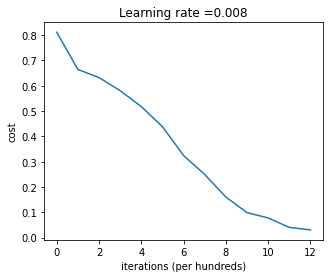

Accuracy: 0.78


In [37]:
parameters = L_layer_model(train_x, train_y, layers_dims, learning_rate = 0.008, num_iterations = 1300, print_cost = True)
pred_test = predict(test_x, test_y, parameters)

### 9.3 - Weight initialization

We modified the parameter initialization function to also include Xavier's initialization for comparison with Kaiming's initialization. We also include a seed selector to see how the random component of the weight initializations can lead to different results.

In [38]:
def initialize_parameters_deep(layer_dims, init='Kaiming', seed=3):
    np.random.seed(seed)
    parameters = {}
    L = len(layer_dims)    

    for l in range(1, L):
        if init == 'Kaiming':
          parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1])*np.sqrt(2/layer_dims[l-1])
        elif init == 'Xavier':
          parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1])*np.sqrt(6/(layer_dims[l] + layer_dims[l-1]))
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
    return parameters


def L_layer_model(X, Y, layers_dims, learning_rate = 0.009, num_iterations = 2000, print_cost=False, initialization='Kaiming', seed=3):
    np.random.seed(1)
    costs = []                        
    
    parameters = initialize_parameters_deep(layers_dims, init=initialization, seed=seed)
    
    for i in range(0, num_iterations):
        AL, caches = L_model_forward(X, parameters)
        cost = compute_cost(AL, Y)
        grads = L_model_backward(AL, Y, caches)
        parameters = update_parameters(parameters, grads, learning_rate)
                
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
            
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

If we compare the next MLP with the best MLP in 9.2, we can see how (with the same configuration) Kaiming's initialization achieves better results  than Xavier's initialization (0.78 vs 0.7 accuracy).

Cost after iteration 0: 1.934613
Cost after iteration 100: 0.653561
Cost after iteration 200: 0.605958
Cost after iteration 300: 0.568919
Cost after iteration 400: 0.537393
Cost after iteration 500: 0.486523
Cost after iteration 600: 0.415458
Cost after iteration 700: 0.405633
Cost after iteration 800: 0.415306
Cost after iteration 900: 0.255491
Cost after iteration 1000: 0.215696
Cost after iteration 1100: 0.205155
Cost after iteration 1200: 0.358252


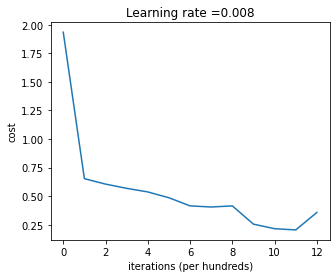

Accuracy: 0.7000000000000001


In [39]:
parameters = L_layer_model(train_x, train_y, layers_dims, learning_rate = 0.008, num_iterations = 1300, print_cost = True, initialization = 'Xavier', seed=3)
pred_test = predict(test_x, test_y, parameters)

In the following cell of code we can see how the random initialization of neuron weights varies the obtained results. (88 seed-> 0.7 accuracy, 134 seed-> 0.74 accuracy, 3 seed-> 0.78 accuracy).

Cost after iteration 0: 0.676921
Cost after iteration 100: 0.471522
Cost after iteration 200: 0.364523
Cost after iteration 300: 0.369129
Cost after iteration 400: 0.326755
Cost after iteration 500: 0.153770
Cost after iteration 600: 0.110989
Cost after iteration 700: 0.122210
Cost after iteration 800: 0.081986
Cost after iteration 900: 0.049940
Cost after iteration 1000: 0.038096
Cost after iteration 1100: 0.027093
Cost after iteration 1200: 0.020015


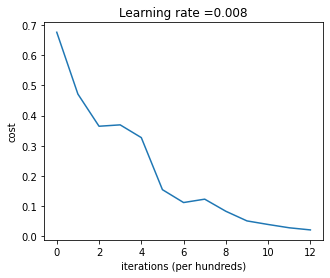

Accuracy: 0.7
Cost after iteration 0: 0.698350
Cost after iteration 100: 0.580115
Cost after iteration 200: 0.486554
Cost after iteration 300: 0.442439
Cost after iteration 400: 0.374152
Cost after iteration 500: 0.311872
Cost after iteration 600: 0.272455
Cost after iteration 700: 0.225297
Cost after iteration 800: 0.069362
Cost after iteration 900: 0.040089
Cost after iteration 1000: 0.026155
Cost after iteration 1100: 0.018250
Cost after iteration 1200: 0.013512


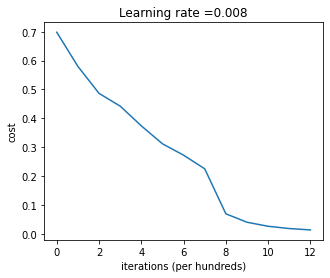

Accuracy: 0.74


In [40]:
parameters = L_layer_model(train_x, train_y, layers_dims, learning_rate = 0.008, num_iterations = 1300, print_cost = True, seed=88)
pred_test = predict(test_x, test_y, parameters)

parameters = L_layer_model(train_x, train_y, layers_dims, learning_rate = 0.008, num_iterations = 1300, print_cost = True, seed=134)
pred_test = predict(test_x, test_y, parameters)

### 9.4 - Complexity

Three models are presented below. The first is the most complex, it has 3 hidden layers of 30, 30 and 15 neurons. The second is the simplest, it has only 1 hidden layer of 2 neurons. The third one is somewhere in between.

If we look at the training error and accuracy of each, we can see how:

- The first model is overfitted. It is the one that reduces the training error the most (until 0.029), but has a low accuracy (0.7). This means that the model is so complex that is too suited to the training data, losing generality and performing worse on new data.

- For second one, the simplicity of the model does not allow the features of the training data to be adequately modeled. The training error remains the highest (0.64) and the accuracy the lowest (0.34). 

- The third model is adequate (neither too much nor too little complex) and best predicts the test data (0.76 accuracy).

Cost after iteration 0: 0.655005
Cost after iteration 100: 0.511840
Cost after iteration 200: 0.429635
Cost after iteration 300: 0.358668
Cost after iteration 400: 0.324970
Cost after iteration 500: 0.270827
Cost after iteration 600: 0.179260
Cost after iteration 700: 0.158752
Cost after iteration 800: 0.074815
Cost after iteration 900: 0.055873
Cost after iteration 1000: 0.043458
Cost after iteration 1100: 0.035051
Cost after iteration 1200: 0.029208


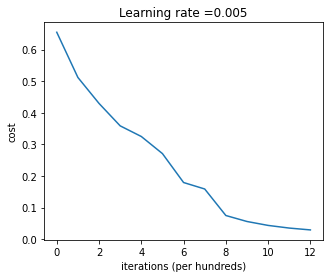

Accuracy: 0.7


Cost after iteration 0: 0.715909
Cost after iteration 100: 0.677169
Cost after iteration 200: 0.666468
Cost after iteration 300: 0.659268
Cost after iteration 400: 0.654407
Cost after iteration 500: 0.651112
Cost after iteration 600: 0.648870
Cost after iteration 700: 0.647341
Cost after iteration 800: 0.646293
Cost after iteration 900: 0.645575
Cost after iteration 1000: 0.645080


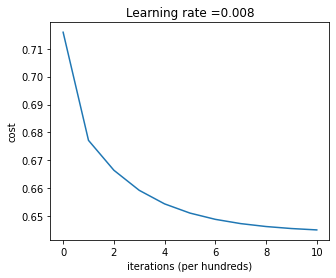

Accuracy: 0.3400000000000001


Cost after iteration 0: 0.695248
Cost after iteration 100: 0.568319
Cost after iteration 200: 0.495122
Cost after iteration 300: 0.444131
Cost after iteration 400: 0.380181
Cost after iteration 500: 0.314319
Cost after iteration 600: 0.234462
Cost after iteration 700: 0.186505
Cost after iteration 800: 0.135457
Cost after iteration 900: 0.097508
Cost after iteration 1000: 0.083330
Cost after iteration 1100: 0.061467
Cost after iteration 1200: 0.046181
Cost after iteration 1300: 0.036123


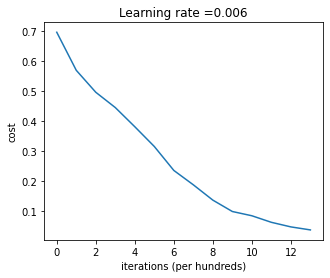

Accuracy: 0.76


In [41]:
# 1st model
layers_dims = [12288, 30, 30, 15, 1]
parameters = L_layer_model(train_x, train_y, layers_dims, learning_rate = 0.005, num_iterations = 1300, print_cost = True)
pred_test = predict(test_x, test_y, parameters)
print("\n")

# 2nd model
layers_dims = [12288, 2, 1]
parameters = L_layer_model(train_x, train_y, layers_dims, learning_rate = 0.008, num_iterations = 1100, print_cost = True)
pred_test = predict(test_x, test_y, parameters)
print("\n")

# 3rd model
layers_dims = [12288, 10, 6, 1]
parameters = L_layer_model(train_x, train_y, layers_dims, learning_rate = 0.006, num_iterations = 1400, print_cost = True)
pred_test = predict(test_x, test_y, parameters)

### 9.5 - Final meta-parameters

After putting together all the above concepts and testing some hyperparameters, the best model obtained is:

Cost after iteration 0: 0.695248
Cost after iteration 100: 0.576166
Cost after iteration 200: 0.509070
Cost after iteration 300: 0.451146
Cost after iteration 400: 0.416079
Cost after iteration 500: 0.383708
Cost after iteration 600: 0.343200
Cost after iteration 700: 0.300493
Cost after iteration 800: 0.236615
Cost after iteration 900: 0.182517
Cost after iteration 1000: 0.163371
Cost after iteration 1100: 0.119943
Cost after iteration 1200: 0.074192
Cost after iteration 1300: 0.056842


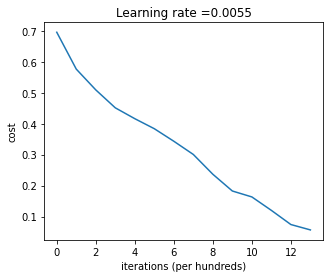

Accuracy: 0.78


In [42]:
layers_dims = [12288, 10, 6, 1]
lr = 0.0055
no_i = 1400
parameters = L_layer_model(train_x, train_y, layers_dims, learning_rate = lr, num_iterations = no_i, print_cost = True)
pred_test = predict(test_x, test_y, parameters)

Compared to the default ([20,7,5,1]), it is simpler (and therefore more computationally efficient) and obtains higher accuracy in test data. 